This file is used to generate a pandas dataframe that contains the corner coordinates of each SCA in a footprint for an new observing strategy. It relies partly on some of the data from the simulation contained on DCC, which can be found in the file 'simple_model_images_files_data.csv.' This file can be used to generate an observing strategy for the following filters: R, Z, J, H, F, K. It cannot be used for the Y filter due to the nature of the simulation data on DCC. There is a separate file for this filter. Some cells will need to be changed depending on the filter. These will be indicated with a markdown cell above them. The value that it needs to be changed to will be in a comment in the cell. I recommend resetting the kernel after each filter, to prevent accidentally reusing variables. 

Note on vocabulary used: 
- Pointing/Exposure: The group of 18 SCAs
- Footprint: The arrangement of many pointings for each observation day.

In [ ]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib
from matplotlib import pyplot as plt

In [2]:
#simulation data from DCC fits files
og_df = pd.read_csv('simple_model_images_files_data.csv')

**Change the number here.**

In [3]:
df = og_df[(og_df['POINTING'] == 330)]
#R: 0
#Z: 55
#J: 165
#H: 220
#F: 275
#K: 330

In [4]:
def get_vertices(df, index):
    '''
    Function to convert ra and dec values into vectors compatible with healpy
    Inputs: The dataframe and the index value of the row corresponding to the SCA that will be plotted.
    Outputs: An array of vertices in the form of vectors for each corner of the SCA.
    '''
    ra1 = df['RA1'][index]
    ra2 = df['RA2'][index]
    ra3 = df['RA3'][index]
    ra4 = df['RA4'][index]
    dec1 = df['DEC1'][index]
    dec2 = df['DEC2'][index]
    dec3 = df['DEC3'][index]
    dec4 = df['DEC4'][index]
    def ra_dec_to_theta_phi(ra, dec):
        ra_rad = np.radians(ra)
        dec_rad = np.radians(dec)
        theta = np.pi / 2 - dec_rad
        phi = ra_rad
        return theta, phi
    theta1, phi1 = ra_dec_to_theta_phi(ra1, dec1)
    theta2, phi2 = ra_dec_to_theta_phi(ra2, dec2)
    theta3, phi3 = ra_dec_to_theta_phi(ra3, dec3)
    theta4, phi4 = ra_dec_to_theta_phi(ra4, dec4)
    vec1 = hp.ang2vec(theta1, phi1)
    vec2 = hp.ang2vec(theta2, phi2)
    vec3 = hp.ang2vec(theta3, phi3)
    vec4 = hp.ang2vec(theta4, phi4)
    vertices = np.array([vec1, vec2, vec3, vec4])
    return vertices

In [5]:
NSIDE = 4096
NPIX  = hp.nside2npix(NSIDE)

In [6]:
def translate_squares(df, shift=0.01, upward_repetitions=1, left_translation=True, downward_repetitions=1):
    """
    Function to create the tiling of the footprint, following the snake pattern outlined in (Wang et al., 2023). It works left to right if visualized using healpy gnomview(). 
    Arguments:
        df: Must be a dataframe that contains only one pointing (only 18 rows). Contains columns RA{i} and DEC{i} for the 4 corner coordinates of every SCA.
        shift: change this value to alter the spacing between rows of pointings. (Increase it and the space between decreases and vice versa.)
        upward_repetitions: One less than the number of desired rows
        left translation: True if another column is desired.
        downward_repetitions: One less than the number of desired rows
    Output: Original dataframe with the rows corresponding to the new pointings appended to the end.
    
    """
    # Step 1: Identify the bounding box
    single_pointing = df.tail(18)
    min_dec = single_pointing[['DEC1', 'DEC2', 'DEC3', 'DEC4']].min().min()
    max_dec = single_pointing[['DEC1', 'DEC2', 'DEC3', 'DEC4']].max().max()
    

    # Step 2: Calculate the upward translation distance
    translation_distance_up = max_dec - min_dec - shift

    # Initialize the result dataframe with the original data
    result_df = df.copy()

    # Step 3: Apply the upward translations
    for i in range(upward_repetitions):
        # Translate each corner's Dec coordinates upward
        translated_df = single_pointing.copy()
        translated_df[['DEC1', 'DEC2', 'DEC3', 'DEC4']] += (i + 1) * translation_distance_up
        
        # Append the translated squares to the result dataframe
        result_df = pd.concat([result_df, translated_df], ignore_index=True)

    if left_translation:
        # Step 4: Extract the last set of translated squares
        last_set = result_df.tail(18)
        
        # Step 5: Calculate the left translation distance
        min_ra = last_set[['RA1', 'RA2', 'RA3', 'RA4']].min().min()
        max_ra = last_set[['RA1', 'RA2', 'RA3', 'RA4']].max().max()
        translation_distance_left = max_ra - min_ra - shift
        
        # Step 6: Apply the left translation to the last set
        last_set_left_translated = last_set.copy()
        last_set_left_translated[['RA1', 'RA2', 'RA3', 'RA4']] += translation_distance_left

        # Append the left-translated squares to the result dataframe
        result_df = pd.concat([result_df, last_set_left_translated], ignore_index=True)

        # Step 7: Apply the downward translations to the left-translated set
        for i in range(downward_repetitions):
            downward_translated_df = last_set_left_translated.copy()
            downward_translated_df[['DEC1', 'DEC2', 'DEC3', 'DEC4']] -= (i + 1) * translation_distance_up
            result_df = pd.concat([result_df, downward_translated_df], ignore_index=True)

    return result_df

### 8*5 with corners removed = 36 exposures

In [7]:
#Finishes the first column and makes the second column
trans = translate_squares(df, shift=0.01, upward_repetitions=7, left_translation=True, downward_repetitions=7)

In [8]:
#Starts the third column
trans2 = translate_squares(trans, shift=0.01, upward_repetitions=0, left_translation=True, downward_repetitions=0)

In [9]:
#Finishes the third column and makes the fourth
trans3 = translate_squares(trans2, shift=0.01, upward_repetitions=7, left_translation=True, downward_repetitions=7)

In [10]:
#Starts the fifth column
trans4 = translate_squares(trans3, shift=0.01, upward_repetitions=0, left_translation=True, downward_repetitions=0)

In [11]:
#Finishes the fifth column
new_df = translate_squares(trans4, shift=0.01, upward_repetitions=7, left_translation=False, downward_repetitions=0)

Plotting to check the shape

In [12]:
obs_rows = new_df.index

In [13]:
#iterates through the list of indices for all of the rows that correspond to the SCAs in the new footprint and gets the list of pixels that the SCAs touch.
ipix_box_list = []
for index in obs_rows:
    vertices = get_vertices(new_df, index)
    ipix_box_single = hp.query_polygon(nside=NSIDE, vertices=vertices, inclusive=False)
    ipix_box_list.append(ipix_box_single)
ipix_box = np.concatenate(ipix_box_list)

In [14]:
rot = [9.7, -44] #The point we want our image to be centered on. Not the exact center of the footprint because this is just for visualization.
m = np.zeros(hp.nside2npix(NSIDE)) #these 3 rows create the map that gets fed into healpy
counts = np.bincount(ipix_box, minlength=len(m))
m[:len(counts)] = counts

(Optional) Change the title here

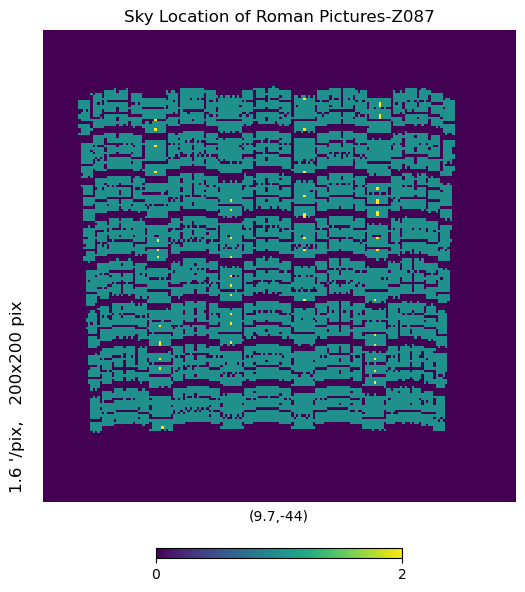

In [15]:
hp.gnomview(m, rot=rot,title="Sky Location of Roman Pictures-Z087", reso = 1.6, xsize = 200) #plots the map centered on "rot". reso is the number of arcminutes per pixel and xsize is the number of pixels.
plt.show()

**Change the filter name here and in the cell directly below.**

In [16]:
K213 = og_df[(og_df['FILTER'] == 'K213')]

In [17]:
sorted_df = K213.sort_values(by='POINTING')

In [18]:
ra1_array = new_df['RA1'].values
ra2_array = new_df['RA2'].values
ra3_array = new_df['RA3'].values
ra4_array = new_df['RA4'].values
dec1_array = new_df['DEC1'].values
dec2_array = new_df['DEC2'].values
dec3_array = new_df['DEC3'].values
dec4_array = new_df['DEC1'].values

In [19]:
SCA_array = new_df['SCA'].values
filter_array = new_df['FILTER'].values
exptime_array = new_df['EXPTIME'].values

In [20]:
pointing_array = sorted_df['POINTING'].values
mjd_array = sorted_df['MJD'].values
dateobs_array = sorted_df['DATE-OBS'].values

In [21]:
data = {
    'POINTING': pointing_array[:720],
    'SCA': SCA_array,
    'FILTER': filter_array,
    'MJD': mjd_array[:720],
    'EXPTIME': exptime_array,
    'DATE-OBS': dateobs_array[:720],
    'RA1': ra1_array,
    'DEC1':dec1_array,
    'RA2': ra2_array,
    'DEC2': dec2_array,
    'RA3': ra3_array,
    'DEC3': dec3_array,
    'RA4': ra4_array,
    'DEC4': dec4_array
}

**For all of these "indices_to_drop" cells change the number.**

In [22]:
nuevo_df = pd.DataFrame(data)

In [23]:
indices_to_drop = nuevo_df[nuevo_df['POINTING'] == 330].index
#R: 0
#Z: 55
#J: 165
#H:220
#F: 275
#K: 330

In [24]:
nuevo_df.drop(indices_to_drop, inplace=True)

In [25]:
indices_to_drop = nuevo_df[nuevo_df['POINTING'] == 337].index
#R: 7
#Z: 62
#J:172
#H: 227
#F: 282
#K: 337

In [26]:
nuevo_df.drop(indices_to_drop, inplace=True)

In [27]:
indices_to_drop = nuevo_df[nuevo_df['POINTING'] == 369].index
#R: 39
#Z: 94
#J: 204
#H: 259
#F: 314
#K: 369

In [28]:
nuevo_df.drop(indices_to_drop, inplace=True)

In [29]:
indices_to_drop = nuevo_df[nuevo_df['POINTING'] == 362].index
#R: 32
#Z: 87
#J: 197
#H: 252
#F: 307
#K: 362

In [30]:
nuevo_df.drop(indices_to_drop, inplace=True)

In [31]:
nuevo_df = nuevo_df.reset_index(drop=True)

In [32]:
obs_rows = nuevo_df.index

In [33]:
ipix_box_list = []
for index in obs_rows:
    vertices = get_vertices(nuevo_df, index)
    ipix_box_single = hp.query_polygon(nside=NSIDE, vertices=vertices, inclusive=False)
    ipix_box_list.append(ipix_box_single)
ipix_box = np.concatenate(ipix_box_list)

In [34]:
rot = [9.7, -44]
m = np.zeros(hp.nside2npix(NSIDE))
counts = np.bincount(ipix_box, minlength=len(m))
m[:len(counts)] = counts

(Optional) Change the title here.

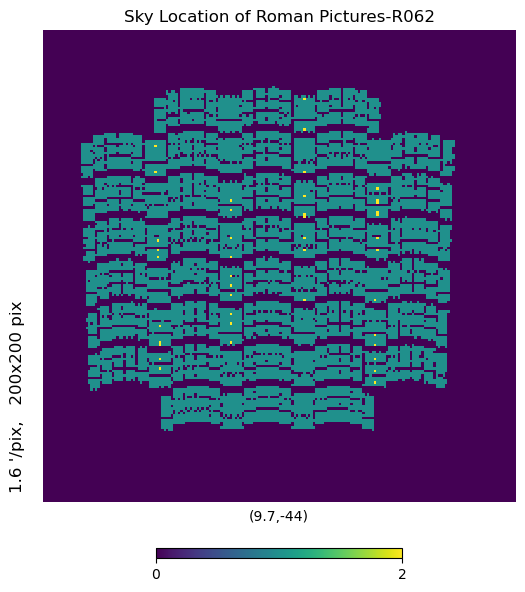

In [35]:
hp.gnomview(m, rot=rot,title="Sky Location of Roman Pictures-R062", reso = 1.6, xsize = 200)
plt.show()

In [36]:
def rotate_point(x, y, angle_rad):
    """Rotate a point clockwise by a given angle around the origin (0, 0)."""
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)
    
    x_new = cos_angle * x + -sin_angle * y
    y_new = sin_angle * x + cos_angle * y
    
    return x_new, y_new

In [37]:
def rotate_squares(df, foot_angle_deg):
    '''
    Function to rotate the footprint clockwise once as viewed in the gnomview projection. 
    Commented out, there is code to also rotate individual pointings if desired. The angle of rotation and a list of lists of indices corresponding to the groups of SCAs in a pointing would need to be added as arguments in the function.
    The previous names for these arguments were point_angle_deg and subset_indices_list.
    Inputs: 
        Dataframe that contains the rows for the footprint. 
        foot_angle_deg is the rotation angle in degrees that you want to rotate the footprint by.
    Output: A dataframe of corner ra and dec coordinates for the rotated footprint. (If angle is 0 then it is the ra and dec coordinates for the original footprint).    
    '''
    # Convert angles from degrees to radians
    angle_rad = np.radians(foot_angle_deg)
    #subset_angle_rad = np.radians(point_angle_deg) 

    # Calculate the center of the entire set
    ra_center = df[[f'RA{i}' for i in range(1, 5)]].values.mean()
    dec_center = df[[f'DEC{i}' for i in range(1, 5)]].values.mean()

    # Initialize an empty DataFrame to store rotated squares
    rotated_data = {f'RA{i}': [] for i in range(1, 5)}
    rotated_data.update({f'DEC{i}': [] for i in range(1, 5)})

    # Apply the initial rotation to the entire set
    for index, row in (df.tail(648)).iterrows():
        for i in range(1, 5):
            ra, dec = row[f'RA{i}'], row[f'DEC{i}']

            # Translate points to origin (center of the entire set)
            ra_translated = ra - ra_center
            dec_translated = dec - dec_center

            # Rotate the points
            ra_rot, dec_rot = rotate_point(ra_translated, dec_translated, angle_rad)

            # Translate points back to the original position
            rotated_data[f'RA{i}'].append(ra_rot + ra_center)
            rotated_data[f'DEC{i}'].append(dec_rot + dec_center)

    # Create a DataFrame for the initially rotated squares
    rotated_df = pd.DataFrame(rotated_data)

    # Apply the additional rotation to each subset
    #for subset_indices in subset_indices_list:
     #   subset_df = rotated_df.iloc[subset_indices]
      #  ra_center_subset = subset_df[[f'RA{i}' for i in range(1, 5)]].values.mean()
       # dec_center_subset = subset_df[[f'DEC{i}' for i in range(1, 5)]].values.mean()
        
        #for index in subset_indices:
         #   row = rotated_df.loc[index]
          #  for i in range(1, 5):
           #     ra, dec = row[f'RA{i}'], row[f'DEC{i}']

                # Translate points to origin (center of the subset)
              #  ra_translated = ra - ra_center_subset
               # dec_translated = dec - dec_center_subset

                # Rotate the points
                #ra_rot, dec_rot = rotate_point(ra_translated, dec_translated, subset_angle_rad)

                # Translate points back to the original position
                #rotated_df.at[index, f'RA{i}'] = ra_rot + ra_center_subset
                #rotated_df.at[index, f'DEC{i}'] = dec_rot + dec_center_subset

    # Concatenate the original and rotated DataFrames
    #result_df = pd.concat([df, rotated_df], ignore_index=True)
    result_df = rotated_df

    return result_df

In [39]:
#This gets the list of days used to calculate the rotation angle of the footprint.
list1 = list(range(0, 726, 5)) #The 725 days of the observation period
list2 = [1550, 1555, 1560] #The small 10 day observation period

In [40]:
#360 degrees divided by 365 days times number of days = how much it has rotated on a given day

In [41]:
#Gets a list of angles for each day to rotate the footprint by.
foot_angles_list = []

for day in list1:
    angle = (360 / 365) * day
    foot_angles_list.append(angle)

In [42]:
#Gets a list of angles for each day to rotate the individual pointings by.
#point_angles_list = []
#deg = 1

#for day in list1:
 #   angle = deg * day
  #  point_angles_list.append(angle)

In [44]:
#Gets the list of lists of SCAs for each pointing in the footprint. Used for rotating the individual pointings.
#group_size = 18
#num_rows = len(nuevo_df)
#indices = nuevo_df.index.tolist()

#list_of_lists = []
#for i in range(0, num_rows, group_size):
 #   list_of_lists.append(indices[i:i + group_size])

In [45]:
#This is the format of the loop needed if there is an individual pointing rotation.
#result_df = pd.DataFrame()

#for foot_angle, point_angle in zip(foot_angles_list, point_angles_list):
    # Rotate the original DataFrame by the current angle
 #   rotated_df = rotate_squares(nuevo_df, foot_angle, point_angle, list_of_lists)
    # Append the rotated DataFrame to the result
  #  result_df = pd.concat([result_df, rotated_df], ignore_index=True)

# Add the original data separately to avoid duplication
#result_df = pd.concat([nuevo_df, result_df.iloc[len(nuevo_df):]], ignore_index=True)

In [46]:
#This calls the function for every angle, making a dataframe with ra and dec coordinates of the corners of the SCAs in the footprint for all angles covered in the 725 days.
result_df = pd.DataFrame()

for foot_angle in foot_angles_list:
    # Rotate the original DataFrame by the current angle
    rotated_df = rotate_squares(nuevo_df, foot_angle)
    # Append the rotated DataFrame to the result
    result_df = pd.concat([result_df, rotated_df], ignore_index=True)

In [47]:
result_df

,RA1,RA2,RA3,RA4,DEC1,DEC2,DEC3,DEC4
0,7.029217,7.032768,7.209526,7.206366,-45.363696,-45.240500,-45.240019,-45.363696
1,7.596622,7.595908,7.420693,7.421770,-44.874148,-44.991030,-44.991469,-44.874148
2,7.809333,7.806866,7.982991,7.985836,-45.149774,-45.029628,-45.030469,-45.149774
3,7.809069,7.806899,7.984775,7.987336,-45.297976,-45.175284,-45.175660,-45.297976
4,7.613938,7.613531,7.790317,7.791102,-45.123302,-45.003435,-45.003995,-45.123302
...,...,...,...,...,...,...,...,...
94603,12.082352,12.093541,12.269656,12.258808,-42.910830,-42.791512,-42.806286,-42.926056
94604,12.848778,12.843145,12.670127,12.675964,-42.819250,-42.937610,-42.920811,-42.804339
94605,12.068393,12.080054,12.257936,12.246664,-43.057703,-42.935745,-42.951082,-43.073085
94606,12.085811,12.073106,11.898920,11.912090,-42.686838,-42.803515,-42.789682,-42.671849


In [48]:
#This calculates the center of each pointing
ra_centers = []
dec_centers = []
# Loop through the DataFrame in chunks of 'subset_size'
for i in range(0, len(result_df), 18):
    subset = result_df.iloc[i:i + 18]
        
    # Calculate the mean RA and Dec for the subset
    ra_center = subset[[f'RA{j}' for j in range(1, 5)]].values.mean()
    dec_center = subset[[f'DEC{j}' for j in range(1, 5)]].values.mean()
        
    ra_centers.append(ra_center)
    dec_centers.append(dec_center)

In [49]:
ras_array = [item for item in ra_centers for _ in range(18)] #repeat the value 18 times for each of the 18 SCA rows.
decs_array = [item for item in dec_centers for _ in range(18)]

In [50]:
#Calculates the overall footprint center
ra_center = nuevo_df[[f'RA{i}' for i in range(1, 5)]].values.mean() #gets the RA values from all 4 columns and calculates the mean.
dec_center = nuevo_df[[f'DEC{i}' for i in range(1, 5)]].values.mean() #gets the Dec values from all 4 columns and calculates the mean.

In [51]:
#Repeat the number 94608 times for all of the rows in the dataframe because the footprint center stays constant.
ra_center_array = [ra_center]*94608
dec_center_array = [dec_center]*94608

In [53]:
#point_angles_array = [item for item in point_angles_list for _ in range(648)]

In [54]:
foot_angles_array = [item for item in foot_angles_list for _ in range(648)] #repeat 648 times for all of the rows in each footprint.

**Change the filter name here.**

In [55]:
#get the original mjd values from the DCC simulations.
mjd = og_df[(og_df['FILTER'] == 'K213')]['MJD'].values

In [56]:
#There are repeats because of the SCAs so they need to be taken out for now.
mjd = np.unique(mjd)

In [85]:
#DCC sims had 55 pointings per footprint but mine only needs 36. Getting the first 36 mjd values for each day.
result = []
for i in range(0, len(mjd), 55):
    # Get the first 36 values from the current group of 55
    group_values = mjd[i:i + 36]
    result.extend(group_values)

In [58]:
result = result[:5256] #cuts off the values for the 10 day observation period

In [59]:
mjd_array = [item for item in result for _ in range(18)] #repeat for each SCA.

**Change the filter name here.**

In [60]:
#DCC sims datetime values
date = og_df[(og_df['FILTER'] == 'K213')]['DATE-OBS'].values

In [61]:
#get rid of repeats
date = np.unique(date)

In [62]:
#Getting first 36 datetime values per day.
result = []
for i in range(0, len(date), 55):
    # Get the first 36 values from the current group of 55
    group_values = date[i:i + 36]
    result.extend(group_values)

In [63]:
result = result[:5256] #cut out 10 days of observation

In [64]:
date_obs_array = [item for item in result for _ in range(18)] #repeat values

**Need to change the start value here.**

In [65]:
#This generates the new pointing values, following the same pattern that the DCC sims.
#The pointings go like this: Tile a footprint for each filter in the order of R,Z,Y,J,H,F,K. Then for each rotation angle it goes through this order again.

pointings = []
# Start value for the first block
start_value = 252
#R: 0
#Z: 36
#J: 108
#H: 144
#F: 180
#K: 216


# Create the list using a loop
for block in range(146):
    # Create the current block of consecutive numbers
    block_values = list(range(start_value, start_value + 36))
    # Append the block to the result list
    pointings.extend(block_values)
    # Update the start value for the next block
    start_value = block_values[-1] + 1 + 216

In [66]:
pointing_array = [item for item in pointings for _ in range(18)]

**Change the filter name here**

In [67]:
sorted_df = K213.sort_values(by='POINTING')

In [68]:
filter_array = sorted_df['FILTER'].values

In [69]:
exp_time = sorted_df['EXPTIME'].values

In [70]:
SCAs = df['SCA'].values

In [71]:
SCA_array = np.tile(SCAs, 5256) #repeats the SCAs in their same order for every pointing. 

In [72]:
result_df.insert(0, 'POINTING', pointing_array)

In [73]:
result_df.insert(1, 'SCA', SCA_array)

In [74]:
result_df['SCA'] = result_df['SCA'].astype(int)

In [75]:
result_df.insert(2, 'FILTER', filter_array[:94608])

In [76]:
result_df.insert(3, 'MJD', mjd_array)

In [77]:
result_df.insert(4, 'EXPTIME', exp_time[:94608])

In [78]:
result_df.insert(5, 'DATE-OBS', date_obs_array)

In [79]:
result_df.insert(6, 'EXP CENTER- RA', ras_array) #Exposure center = center of every exposure
result_df.insert(7, 'EXP CENTER- DEC', decs_array) 
#result_df.insert(8, 'MINOR ROT ANGLE', point_angles_array) #rotation angle of the individual pointings

In [80]:
result_df.insert(8, 'MAJOR ROT AXS- RA', ra_center_array) #major rotation axis = The footprint center
result_df.insert(9, 'MAJOR ROT AXS- DEC', dec_center_array)
result_df.insert(10, 'MAJOR ROT ANGLE', foot_angles_array) #major rotation angle = all of the rotation angles for the footprint

In [81]:
result_df

,POINTING,SCA,FILTER,MJD,EXPTIME,DATE-OBS,EXP CENTER- RA,EXP CENTER- DEC,MAJOR ROT AXS- RA,MAJOR ROT AXS- DEC,MAJOR ROT ANGLE,RA1,RA2,RA3,RA4,DEC1,DEC2,DEC3,DEC4
0,252,16,K213,62002.33849,901.175,2028-08-19 08:07:25.536000,7.60534,-45.108231,9.889758,-43.909362,0.000000,7.029217,7.032768,7.209526,7.206366,-45.363696,-45.240500,-45.240019,-45.363696
1,252,12,K213,62002.33849,901.175,2028-08-19 08:07:25.536000,7.60534,-45.108231,9.889758,-43.909362,0.000000,7.596622,7.595908,7.420693,7.421770,-44.874148,-44.991030,-44.991469,-44.874148
2,252,5,K213,62002.33849,901.175,2028-08-19 08:07:25.536000,7.60534,-45.108231,9.889758,-43.909362,0.000000,7.809333,7.806866,7.982991,7.985836,-45.149774,-45.029628,-45.030469,-45.149774
3,252,4,K213,62002.33849,901.175,2028-08-19 08:07:25.536000,7.60534,-45.108231,9.889758,-43.909362,0.000000,7.809069,7.806899,7.984775,7.987336,-45.297976,-45.175284,-45.175660,-45.297976
4,252,2,K213,62002.33849,901.175,2028-08-19 08:07:25.536000,7.60534,-45.108231,9.889758,-43.909362,0.000000,7.613938,7.613531,7.790317,7.791102,-45.123302,-45.003435,-45.003995,-45.123302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94603,36827,11,K213,62727.81100,901.175,2030-08-14 19:27:50.400000,12.26878,-42.911312,9.889758,-43.909362,715.068493,12.082352,12.093541,12.269656,12.258808,-42.910830,-42.791512,-42.806286,-42.926056
94604,36827,9,K213,62727.81100,901.175,2030-08-14 19:27:50.400000,12.26878,-42.911312,9.889758,-43.909362,715.068493,12.848778,12.843145,12.670127,12.675964,-42.819250,-42.937610,-42.920811,-42.804339
94605,36827,10,K213,62727.81100,901.175,2030-08-14 19:27:50.400000,12.26878,-42.911312,9.889758,-43.909362,715.068493,12.068393,12.080054,12.257936,12.246664,-43.057703,-42.935745,-42.951082,-43.073085
94606,36827,15,K213,62727.81100,901.175,2030-08-14 19:27:50.400000,12.26878,-42.911312,9.889758,-43.909362,715.068493,12.085811,12.073106,11.898920,11.912090,-42.686838,-42.803515,-42.789682,-42.671849


**Change the file name.**

In [82]:
result_df.to_csv('K213_files_data.csv', index=False)